#### Task 1: 
- Team: (20 points)
    - Develop Linear and Non-Linear (polynomial with degree n) regression models for predicting cases and deaths in US. 
        - Start your data from 2020.06.01 (Monday) to 2021.01.03 (Sunday) of infections in US.
            X-Axis - number of days, Y-Axis - number of new cases and deaths. (5 points)
        - Calculate and report Root Mean Square Error (RMSE) for your models (linear and non-linear). https://en.wikipedia.org/wiki/Root-mean-square_deviation. Discuss bias versus variance tradeoff. (5 points)
        - Plot trend line along for the data along with the forecast of 1 week ahead (i.e. make prediction on 2021.01.04 - 2021.01.10). (5 points)
        - Describe the trends as compared to other countries. (5 points)

In [1]:
#!pip install --user ipykernel
#!pip install sktime
#!pip install ipython
#!pip install -U kaleido

In [2]:
#imports
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sklearn.metrics import mean_squared_error
from sktime.utils.plotting import plot_series
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import IPython
import kaleido
import plotly.express as px
import plotly.graph_objects as go
import math

In [3]:
#read in csv files
cases = pd.read_csv("covid_confirmed_usafacts.csv")
deaths = pd.read_csv("covid_deaths_usafacts.csv")

In [4]:
def get_dates(data): #function from stage 2
    dates = data.loc[:, [i not in ["countyFIPS","County Name", "State", "StateFIPS"] for i in data]] #Extract non dates
    
    dates.columns = pd.to_datetime(dates.columns) #Fix columns to be date times
    
    dates = dates.loc[:, [(i >= datetime.datetime(2020, 5, 25)) and (i <= datetime.datetime(2021, 1, 10)) for i in dates]] #Extract correct time
    return dates #make dates start 1 week earlier for get_weekly() purposes

def get_weekly(dates): #tweaked function from stage 2

    weeks = [range(i, i + 7) for i in range(0, len(dates.columns), 7)]
    dates.iloc[:, weeks[0]]
    
    stats = pd.DataFrame({"week": [],"sum" : []})
    
    for i in range(len(weeks)-1):
        date = dates.iloc[:, weeks[i+1]].iloc[0, :].keys()[0]
        #Subtract numbers from previous week to get new case/death data (current data is cumulative)
        week = (dates.iloc[:, weeks[i+1]].sum(axis = 1)) - (dates.iloc[:, weeks[i]].sum(axis = 1))
        wsum = week.sum()/7/7
        new_row = pd.DataFrame({"week": date,"sum" : (wsum)}, index=[i])
        stats = pd.concat([stats, new_row])
    return stats

In [5]:
#set up data
cases_dates = get_dates(cases)
cases_weeks = get_weekly(cases_dates)
cases_weeks.dropna(inplace=True)
deaths_dates = get_dates(deaths)
deaths_weeks = get_weekly(deaths_dates)
deaths_weeks.dropna(inplace=True)

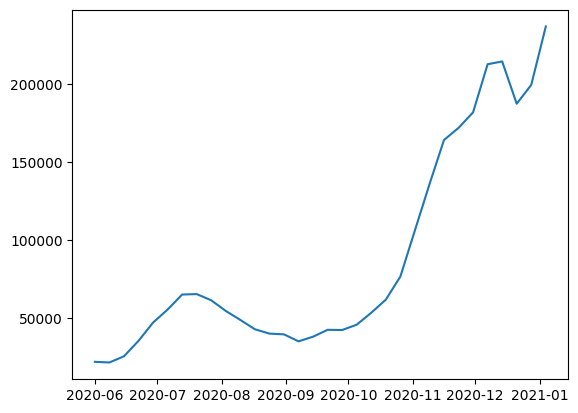

In [6]:
#plot actual case data
plt.plot(cases_weeks["week"], cases_weeks["sum"])

In [19]:
#currently tweaking this one
def create_plot(data_weekly, degree = 1, title = None):
    #data_dates = get_dates(data)
    #data_weekly = get_weekly(data_dates)
    #Make cases have an int rather than a date for regression.
    data_weekly["week"] = [i for i in range(len(data_weekly))]
    X = data_weekly["week"]
    y = data_weekly["sum"]
    
    y_train, y_test = temporal_train_test_split(y, test_size=1)
    regressor = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = make_reduction(regressor, window_length=1, strategy="recursive")
    ##X = np.array(data_weekly["week"]).reshape(-1,1)
    
    forecaster.fit(y_train)
    y_predict = forecaster.predict(fh)
    #print(sum(data_weekly["week"])/len(data_weekly["week"]))
    #print(y_err)
    #print(x_err)
    std_error = math.sqrt(mean_squared_error(y_test,y_predict)) 
    #print(std_error)
    
    intervel = 1.96 * std_error
    
    #Initial plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_train.index, y=y_train, mode='lines+markers', name="previous data"))
    fig.add_trace(go.Scatter(x=y_predict.index, y=y_predict, mode='lines+markers', name="predicted values",
                            error_y = {"type": "constant", "value": intervel}))
    fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines+markers', name="true values"))
    
    #fig.add_scatter(x = reg_df["X"], y = reg_df["y"], name = "actual data", mode='lines+markers')
    #fig.add_scatter(x = y_test.index, y = y_test, name = "test data")
    #fig.add_scatter(x = predict_df["X"], y = predict_df["y_predict"], name = "linear prediction", mode='lines+markers',
                    #error_y = {"type": "constant", "value": intervel})
        
    fig.update_layout(xaxis_title='Week', yaxis_title='New Cases/Deaths')
    if title != None:
        #plt.title(title)
        fig.update_layout(title = title)
        
    fig.show()
    #IPython.display.display(IPython.display.Image(fig.to_image(format = "png"))) #Return static image for viewing

In [20]:
# Plot Linear Regression
create_plot(cases_weeks, title="Linear Regression: Cases")
create_plot(deaths_weeks, title="Linear Regression: Deaths")

In [21]:
# Plot Polynomial Regression
degree = 4
create_plot(cases_weeks, degree = degree, title="Polynomial Regression: Cases")
create_plot(deaths_weeks, degree = degree, title="Polynomial Regression: Deaths")